# Content
GradientBoosting classifier models of Dividing v. Differentiating cells
1. Model of birth frame
2. Model of mother division frame
3. Model of mother division frame - group 1diff and 2diff daughters
4. Model of mother division frame -12h

## 0. Load datasets

In [14]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from sklearn import preprocessing, model_selection
from sklearn import ensemble, metrics, inspection

def get_balanced_df_by_category(df,category):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member)
        else:
            output.append(member.sample(num_per_category.min()))
    output = pd.concat(output,ignore_index=True)

    return output


In [2]:
dirnames = {'R1':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R1/',
           'R2':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R2/'}
all_df = []
for name,dirname in dirnames.items():
    _df = pd.read_pickle(path.join(dirname,'Mastodon/single_timepoints_dynamics_aggregated_lookback_history.pkl'))
    _df = _df.drop_duplicates().sort_index().reset_index()
    _df['TrackID'] = name + '_' + _df['TrackID'].astype(str)
    _df = _df.set_index(['Frame','TrackID'])
    _df['Region'] = name
    all_df.append(_df)

all_df = pd.concat(all_df)
all_tracks = {trackID:t for trackID,t in all_df.reset_index().groupby('TrackID')}


In [3]:
len(all_tracks)
all_df['Region']

Frame  TrackID
0      R1_1       R1
       R1_2       R1
       R1_5       R1
       R1_8       R1
       R1_11      R1
                  ..
14     R2_1163    R2
       R2_1173    R2
       R2_1175    R2
       R2_1193    R2
       R2_1198    R2
Name: Region, Length: 15087, dtype: object

## 1. Categorize cell from its birth frame
1. Isolate birth frame data
2. Categorize will differentiate v. will divide

In [4]:
df = all_df[all_df['Fate known','Meta']]
df = df[ ~df['Border','Meta'].astype(bool)]
df = df[ df['Cell type','Meta'] == 'Basal']

births = df[df['Birth frame','Meta']]
births[('Relative basal area','Measurement')] = \
    births['Basal area','Measurement'] / births['Mean adjac Basal area','Measurement']
births['bbox top - diff','Measurement'] = \
    births['Nuclear bbox top','Measurement'] - births['Z','Measurement']
births['bbox bottom - diff','Measurement'] = \
    births['Nuclear bbox bottom','Measurement']-births['Z','Measurement']
births_raw = births.copy()

features2drop = [f for f in births.columns.get_level_values(0) if 'Time to differentiation' in f]
# Censor height information
features2drop = features2drop + ['Z','Mean curvature - cell coords','Z-cyto','Height to BM',
                                 'Basal area','Apical area']
# Censor all exponential rates (but not mother's)
features2drop = features2drop + [f for f in births.columns.get_level_values(0)
                                 if ('exponential' in f and 'frame prior' not in f \
                                         and 'adjac' not in f)]
births = births.drop(columns=features2drop)


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_55709/3508065193.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  births[('Relative basal area','Measurement')] = \
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_55709/3508065193.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  births[('Relative basal area','Measurement')] = \
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_55709/3508065193.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [5]:
births

Name          Nuclear volume Nuclear solidity Nuclear bbox top  \
Metadata         Measurement      Measurement      Measurement   
Frame TrackID                                                    
1     R1_3          116.6250         0.848954             41.0   
      R1_4          101.6875         0.813500             42.0   
      R1_29         151.6250         0.854526             49.0   
      R1_30         143.4375         0.811815             41.0   
      R1_39         138.8750         0.915157             44.0   
...                      ...              ...              ...   
11    R2_1064       160.0625         0.822943             41.0   
      R2_1065       123.1250         0.861767             40.0   
      R2_1112       164.1250         0.833916             38.0   
      R2_1135       228.8750         0.887973             39.0   
12    R2_1091        99.5625         0.789004             45.0   

Name          Nuclear bbox bottom           Y           X Nuclear height  \
Metadata              Measurement Measurement Measurement    Measurement   
Frame TrackID                                                              
1     R1_3                   51.0  107.626340   36.175643          -10.0   
      R1_4                   52.0  106.917179   41.199754          -10.0   
      R1_29                  56.0   22.018343   78.469291           -7.0   
      R1_30                  52.0   18.079521   82.449455          -11.0   
      R1_39                  54.0   47.045792   87.840684          -10.0   
...                           ...         ...         ...            ...   
11    R2_1064                52.0   85.722276   25.094885          -11.0   
      R2_1065                49.0   81.018782   26.719289           -9.0   
      R2_1112                47.0  103.229817   39.728960           -9.0   
      R2_1135                52.0   15.694839   96.979929          -13.0   
12    R2_1091                56.0   81.698211   12.495763          -11.0   

Name          Cell volume      Y-cyto      X-cyto  ...  \
Metadata      Measurement Measurement Measurement  ...   
Frame TrackID                                      ...   
1     R1_3       278.5000  107.838252   36.528950  ...   
      R1_4       294.6250  107.045662   41.284525  ...   
      R1_29      290.7500   22.323893   78.447818  ...   
      R1_30      497.6875   17.353479   82.568693  ...   
      R1_39      345.5625   47.077003   87.742630  ...   
...                   ...         ...         ...  ...   
11    R2_1064    335.0625   85.614438   24.768234  ...   
      R2_1065    373.6875   81.241261   26.383802  ...   
      R2_1112    429.1875  102.970766   39.883974  ...   
      R2_1135    508.8750   15.600774   97.025239  ...   
12    R2_1091    400.3750   81.899313   12.427880  ...   

Name          Median adjac nuc_shcoeffs_L2M5C at 1 frame prior  \
Metadata                                           Measurement   
Frame TrackID                                                    
1     R1_3                                                 NaN   
      R1_4                                                 NaN   
      R1_29                                                NaN   
      R1_30                                                NaN   
      R1_39                                                NaN   
...                                                        ...   
11    R2_1064                                              0.0   
      R2_1065                                              0.0   
      R2_1112                                              0.0   
      R2_1135                                              0.0   
12    R2_1091                                              0.0   

Name          Max adjac nuc_shcoeffs_L0M3C at 1 frame prior  \
Metadata                                        Measurement   
Frame TrackID                                                 
1     R1_3                                              NaN   
      R1_4          

array([[-1.34747106, -0.8101078 , -0.88926136, ..., -0.99395697,
         1.41203407, -0.80225997],
       [-1.89885678,  0.2320124 , -0.88926136, ..., -0.35025462,
         0.32284022, -0.63514735],
       [ 0.32354068, -0.14401603, -0.66324637, ...,  0.09752628,
        -0.07581238,  1.46210047],
       ...,
       [-1.15243943,  0.41377867,  0.46682858, ...,         nan,
         0.4025209 , -0.55621491],
       [-0.03522121, -1.75473199, -0.43723138, ..., -0.3125706 ,
         0.87174895, -0.09139312],
       [ 1.24813507,  0.33449408, -2.4713663 , ..., -0.69091394,
        -1.0352114 ,  3.00386755]])

In [31]:
Niter = 10
metas = pd.DataFrame()
metas['name'] = births.xs('Meta',level=1,axis=1).columns
features = pd.DataFrame()

measurements = births.xs('Measurement',level=1,axis=1)
features['name'] = measurements.columns
features =features.set_index('name')
features['Num NA'] = measurements.isna().sum(axis=0)
# features = features.drop(features.loc[features.index.str.startswith('cyto_')].index)

feature_names = features.index
importances = pd.DataFrame(columns=feature_names)
avg_confusion = np.zeros((Niter,2,2))

for i in tqdm(range(Niter)):
    
    df_ = get_balanced_df_by_category(births, births['Will differentiate','Meta'].values)
    
    y = df_['Will differentiate','Meta']
    X = df_.xs('Measurement',level=1,axis=1).astype(float)
    X = preprocessing.scale(X)
    
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y)
    
    estimator = ensemble.HistGradientBoostingClassifier().fit(X_train,y_train)
    
    y_pred = estimator.predict(X_test)
    avg_confusion[i,...] = metrics.confusion_matrix(y_test,y_pred)/len(y_test)
    
    perm_imps = inspection.permutation_importance(estimator, X, y)
    importances.loc[i] = perm_imps.importances_mean
    

/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:243: RuntimeWarning: Mean of empty slice
  mean_ = np.nanmean(X, axis)
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:251: RuntimeWarning: Mean of empty slice
  mean_1 = np.nanmean(Xr, axis=0)
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:270: RuntimeWarning: Mean of empty slice
  mean_2 = np.nanmean(Xr, axis=0)
/opt/miniconda3/envs/pyt

### Plot birth frame category

In [30]:
measurements

Name           Nuclear volume  Nuclear solidity  Nuclear bbox top  \
Frame TrackID                                                       
1     R1_3           116.6250          0.848954              41.0   
      R1_4           101.6875          0.813500              42.0   
      R1_29          151.6250          0.854526              49.0   
      R1_30          143.4375          0.811815              41.0   
      R1_39          138.8750          0.915157              44.0   
...                       ...               ...               ...   
11    R2_1064        160.0625          0.822943              41.0   
      R2_1065        123.1250          0.861767              40.0   
      R2_1112        164.1250          0.833916              38.0   
      R2_1135        228.8750          0.887973              39.0   
12    R2_1091         99.5625          0.789004              45.0   

Name           Nuclear bbox bottom           Y          X  Nuclear height  \
Frame TrackID                                                               
1     R1_3                    51.0  107.626340  36.175643           -10.0   
      R1_4                    52.0  106.917179  41.199754           -10.0   
      R1_29                   56.0   22.018343  78.469291            -7.0   
      R1_30                   52.0   18.079521  82.449455           -11.0   
      R1_39                   54.0   47.045792  87.840684           -10.0   
...                            ...         ...        ...             ...   
11    R2_1064                 52.0   85.722276  25.094885           -11.0   
      R2_1065                 49.0   81.018782  26.719289            -9.0   
      R2_1112                 47.0  103.229817  39.728960            -9.0   
      R2_1135                 52.0   15.694839  96.979929           -13.0   
12    R2_1091                 56.0   81.698211  12.495763           -11.0   

Name           Cell volume      Y-cyto     X-cyto  ...  \
Frame TrackID                                      ...   
1     R1_3        278.5000  107.838252  36.528950  ...   
      R1_4        294.6250  107.045662  41.284525  ...   
      R1_29       290.7500   22.323893  78.447818  ...   
      R1_30       497.6875   17.353479  82.568693  ...   
      R1_39       345.5625   47.077003  87.742630  ...   
...                    ...         ...        ...  ...   
11    R2_1064     335.0625   85.614438  24.768234  ...   
      R2_1065     373.6875   81.241261  26.383802  ...   
      R2_1112     429.1875  102.970766  39.883974  ...   
      R2_1135     508.8750   15.600774  97.025239  ...   
12    R2_1091     400.3750   81.899313  12.427880  ...   

Name           Max adjac cyto_shcoeffs_L2M1C at 1 frame prior  \
Frame TrackID                                                   
1     R1_3                                           0.969297   
      R1_4                                           0.969297   
      R1_29                                          1.705456   
      R1_30                                          1.705456   
      R1_39                                          1.173407   
...                                                       ...   
11    R2_1064                                        0.395085   
      R2_1065                                        0.395085   
      R2_1112                                        1.424322   
      R2_1135                                        0.978052   
12    R2_1091                                       -0.608437   

Name           Std adjac nuc_shcoeffs_L0M0C at 1 frame prior  \
Frame TrackID                                                  
1     R1_3                                          1.360985   
      R1_4                                          1.360985   
      R1_29                                         1.550392   
      R1_30                                         1.550392   
      R1_39                                         0.671197   
...                                                

name
Relative nuc_shcoeffs_L4M1C                                  0.000446
Median adjac Mean curvature                                  0.000446
Relative Mean FUCCI intensity smoothed growth rate           0.000506
Mean FUCCI intensity smoothed growth rate                    0.000506
Std adjac Distance to closest macrophage at 1 frame prior    0.000506
Std adjac cyto_shcoeffs_L5M2S at 1 frame prior               0.000595
Mean adjac cyto_shcoeffs_L1M0C at 1 frame prior              0.000625
Relative nuc_shcoeffs_L0M0C                                  0.000655
Max adjac nuc_shcoeffs_L5M4S                                 0.000685
Relative Basal area                                          0.000685
Relative Nuclear volume smoothed growth rate                 0.000923
Relative Total H2B intensity smoothed                        0.000923
bbox bottom - diff                                           0.001310
Total H2B intensity smoothed growth rate                     0.002083
Relative Total 

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_55709/423570758.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  importances.mean().sort_values().tail(20).plot.bar(); plt.tight_layout();


Text(33.722222222222214, 0.5, 'Feature importance')

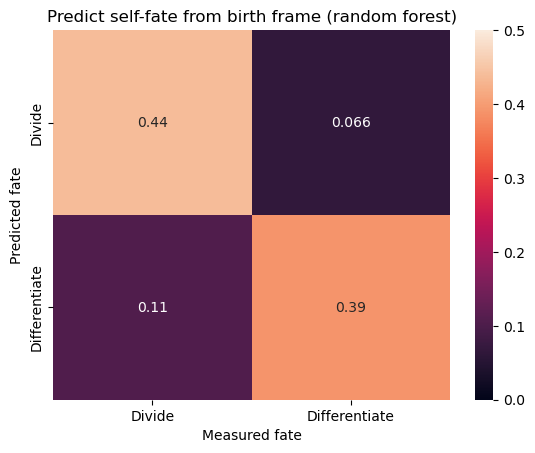

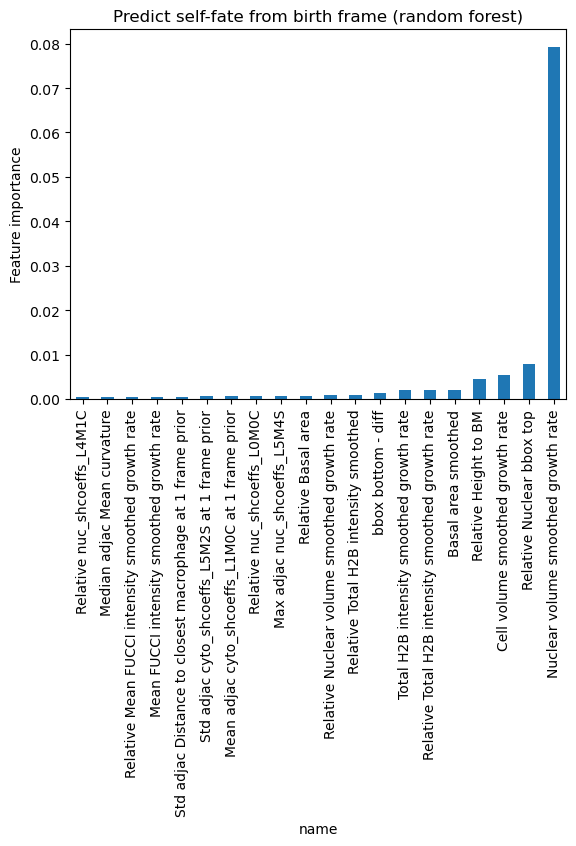

In [32]:

plt.title('Predict self-fate from birth frame (random forest)')
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.gca().set_xticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.gca().set_yticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')

plt.figure()
plt.title('Predict self-fate from birth frame (random forest)')
print(importances.mean().sort_values().tail(20))
importances.mean().sort_values().tail(20).plot.bar(); plt.tight_layout();
plt.ylabel('Feature importance')


/opt/miniconda3/envs/python39/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 6.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 5.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


/opt/miniconda3/envs/python39/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


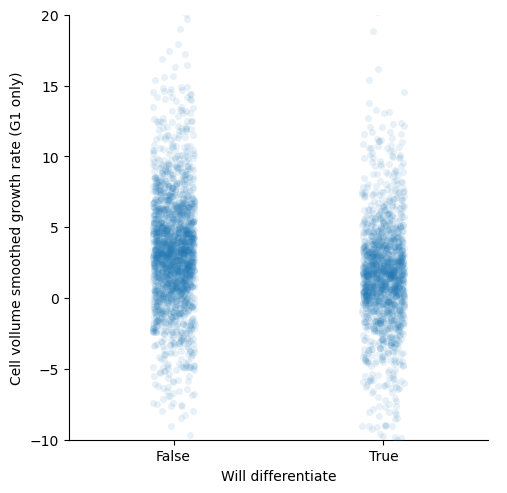

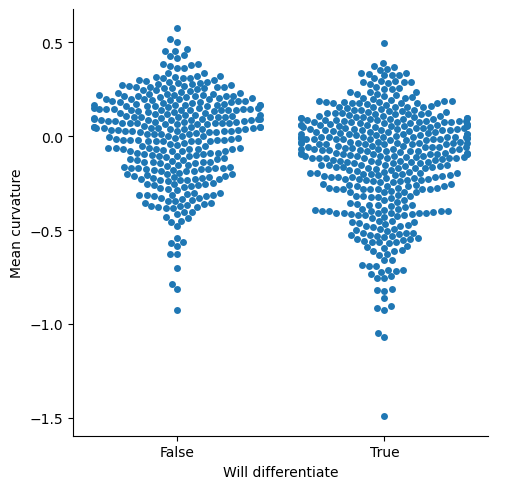

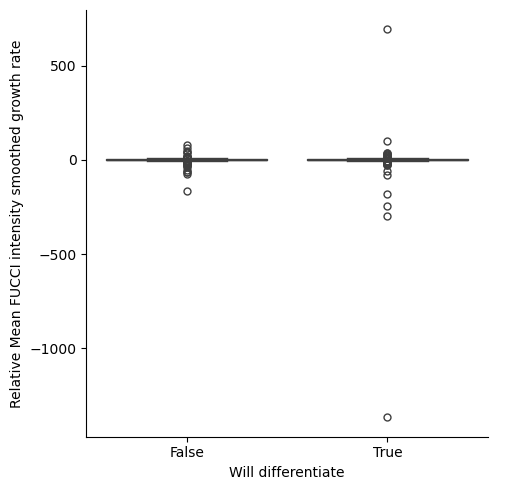

In [85]:
# Visualize features

sb.catplot(all_df[all_df['Fate known','Meta'] & (all_df['Cell cycle phase','Meta'] == 'G1')].droplevel(level=1,axis=1),
           x='Will differentiate',y='Cell volume smoothed growth rate',kind='strip',alpha=0.1)
plt.ylim([-10,20]); plt.ylabel('Cell vollume smoothed growth rate (G1 only)')

# sb.catplot(births_raw.droplevel(level=1,axis=1),x='Will differentiate',y='Cell volume exponential growth rate')

sb.catplot(births_raw.droplevel(level=1,axis=1),x='Will differentiate',y='Mean curvature',kind='swarm')

sb.catplot(births_raw.droplevel(level=1,axis=1),x='Will differentiate',y='Relative Mean FUCCI intensity smoothed growth rate',kind='box')

## 2. Predict daughter fate from mother division frame
Daughter fate: 0 delaminating, 1 delaminating or 2 delaminating

In [87]:
BALANCE = True
Niter = 100

# feature2predict = 'At least one daughter differentiated'
# feature2predict = 'Both daughters differentiated'
feature2predict = 'Num daughter differentiated'

df = all_df[all_df['Fate known','Meta']]
df = df[ df['Cell type','Meta'] == 'Basal']

divisions = df[df[('Divide next frame','Meta')]]
divisions = divisions[~divisions['Border','Meta'].astype(bool)]
divisions = divisions.reset_index().set_index('TrackID')
divisions[('Relative basal area','Measurement')] = \
    divisions['Basal area','Measurement'] / divisions['Mean adjac Basal area','Measurement']


In [88]:
{f:df[f].max() for f in all_df.droplevel(axis=1,level=1).columns if 'Relative' in f}

{'Relative Nuclear volume': Metadata
 Measurement    2.634456
 dtype: object,
 'Relative Nuclear solidity': Metadata
 Measurement    1.495262
 dtype: object,
 'Relative Nuclear bbox top': Metadata
 Measurement    1.231156
 dtype: object,
 'Relative Nuclear bbox bottom': Metadata
 Measurement    1.156627
 dtype: object,
 'Relative Z': Metadata
 Measurement    1.153958
 dtype: object,
 'Relative Y': Metadata
 Measurement    1.365903
 dtype: object,
 'Relative X': Metadata
 Measurement    1.343181
 dtype: object,
 'Relative Nuclear height': Metadata
 Measurement    1.666667
 dtype: object,
 'Relative Cell volume': Metadata
 Measurement    2.622328
 dtype: object,
 'Relative Z-cyto': Metadata
 Measurement    1.171846
 dtype: object,
 'Relative Y-cyto': Metadata
 Measurement    1.282511
 dtype: object,
 'Relative X-cyto': Metadata
 Measurement    1.294165
 dtype: object,
 'Relative Axial component': Metadata
 Measurement    3.125253
 dtype: object,
 'Relative Planar component 1': Metadata
 

In [89]:

features2drop = [f for f in df.columns.get_level_values(0) if 'Time' in f]
features2drop += [f for f in df.columns.get_level_values(0) if 'Age' in f]
features2drop += [f for f in df.columns.get_level_values(0) if 'prior' in f]

features2drop = [(f,'Measurement') for f in features2drop]
features2drop = features2drop + [('Keep until first differentiation','Meta')]
divisions = divisions.drop(columns=features2drop).dropna(
    subset=[(feature2predict,'Meta')])

feature_names = divisions.xs('Measurement',axis=1,level=1).columns
importances = pd.DataFrame(columns=feature_names)
avg_confusion = np.zeros((Niter,3,3))

for i in tqdm(range(Niter)):
    
    if BALANCE:
        df_ = get_balanced_df_by_category(divisions,
                                          divisions[(feature2predict,'Meta')].values)
    else:
        df_ = divisions
        
    _tmp = df_.xs('Measurement',level=1,axis=1).copy()
    _tmp[feature2predict] = df_[(feature2predict,'Meta')].copy()
    
    y = _tmp[feature2predict].values
    X = preprocessing.scale(_tmp.drop(columns=feature2predict))
    
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.1)
    
    forest = ensemble.RandomForestClassifier().fit(X_train,y_train)
    
    y_pred = forest.predict(X_test)
    avg_confusion[i,...] = metrics.confusion_matrix(y_test,y_pred)/len(y_test)
    
    importances.loc[i] = forest.feature_importances_
    


/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:243: RuntimeWarning: Mean of empty slice
  mean_ = np.nanmean(X, axis)
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:251: RuntimeWarning: Mean of empty slice
  mean_1 = np.nanmean(Xr, axis=0)
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:270: RuntimeWarning: Mean of empty slice
  mean_2 = np.nanmean(Xr, axis=0)
/opt/miniconda3/envs/py

In [90]:
_df.droplevel(level=1,axis=1).groupby(feature2predict).count()

Name,Nuclear volume,Nuclear solidity,Nuclear bbox top,Nuclear bbox bottom,Z,Y,X,Nuclear height,Cell volume,Z-cyto,...,Median adjac cyto_shcoeffs_L3M1S at 1 frame prior,Min adjac cyto_shcoeffs_L4M5S at 1 frame prior,Max adjac cyto_shcoeffs_L2M3S at 1 frame prior,Relative Cell volume exponential growth rate at 1 frame prior,Std adjac cyto_shcoeffs_L0M5C at 1 frame prior,Min adjac cyto_shcoeffs_L3M5S at 1 frame prior,Num neighbor division 1 frame prior,Num neighbor delamination 1 frame prior,At least one daughter differentiated,Both daughters differentiated
Num daughter differentiated,,,,,,,,,,,,,,,,,,,,,
0.0,177,177,177,177,177,177,177,177,177,177,...,142,142,142,109,142,142,138,138,177,177
1.0,249,249,249,249,249,249,249,249,249,249,...,186,186,186,126,186,186,163,163,250,250
2.0,213,213,213,213,213,213,213,213,213,213,...,182,182,182,126,182,182,168,168,213,213


Name
Median adjac Cell volume standard        0.002691
Relative nuc_shcoeffs_L0M0C              0.002773
nuc_shcoeffs_L1M0C                       0.002790
Relative Cell volume smoothed            0.002835
Relative basal area                      0.002857
Relative Mean H2B intensity              0.003053
Mean curvature                           0.003182
Relative Z                               0.003377
Height to BM                             0.003430
Basal area smoothed                      0.003919
Mean curvature - cell coords             0.004109
Basal area                               0.004167
Relative Total H2B intensity             0.004590
Relative Nuclear bbox top                0.004853
Relative Basal area smoothed             0.004874
Relative Total H2B intensity smoothed    0.006141
cyto_shcoeffs_L3M0C                      0.007075
Relative Nuclear bbox bottom             0.007425
Relative Basal area                      0.007591
Relative Height to BM                    0.01

Text(24.847222222222214, 0.5, 'Feature importance')

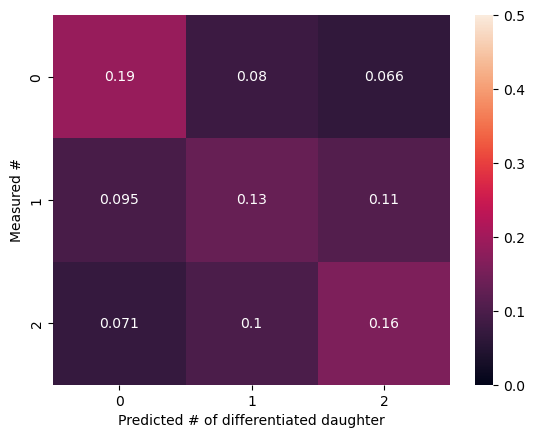

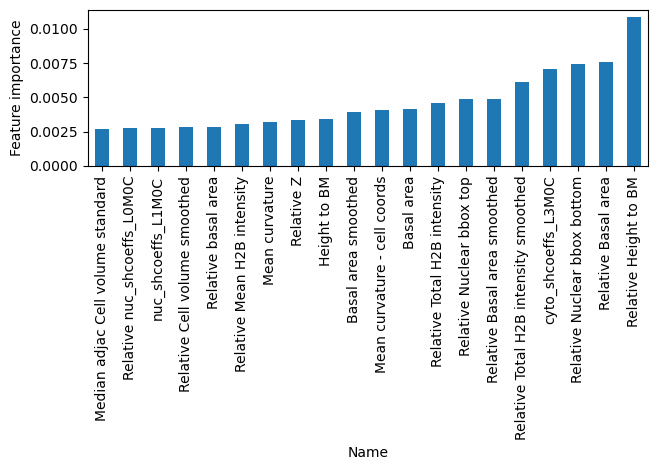

In [91]:
# Plot mother division model results
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.xlabel('Predicted # of differentiated daughter')
plt.ylabel('Measured #')
print(importances.mean().sort_values().tail(20))

plt.figure()
importances.mean().sort_values().tail(20).plot.bar(); plt.tight_layout();
plt.ylabel('Feature importance')


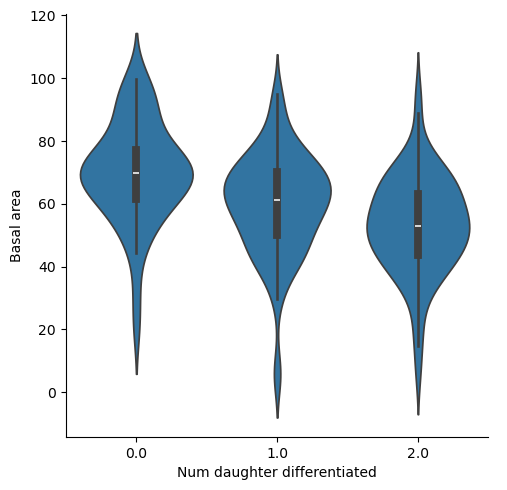

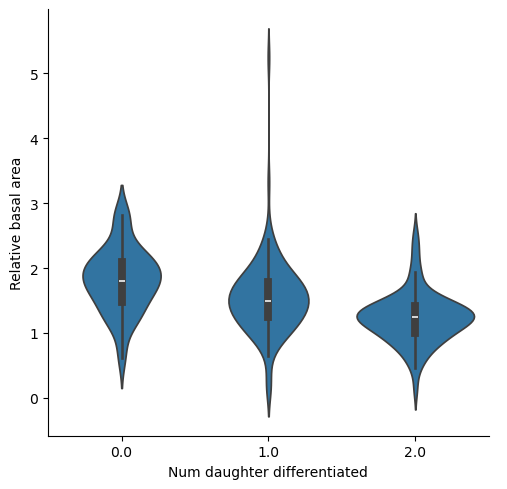

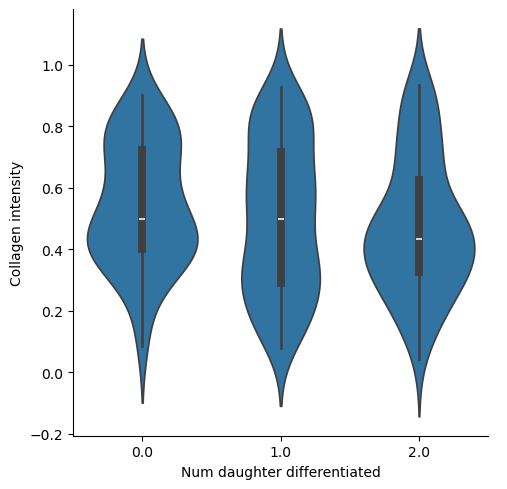

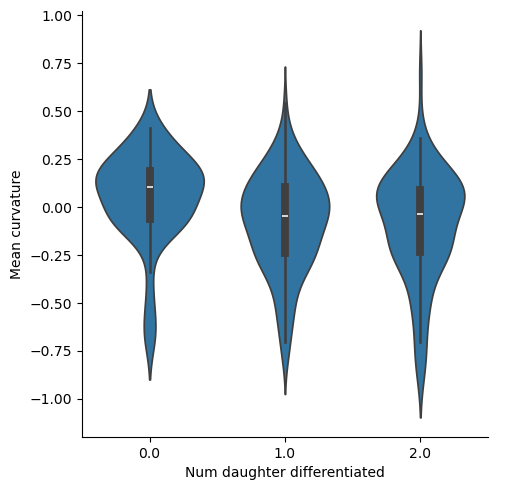

In [51]:
# Visualize features

sb.catplot(divisions.droplevel(level=1,axis=1),x='Num daughter differentiated',y='Basal area',kind='violin')
sb.catplot(divisions.droplevel(level=1,axis=1),x='Num daughter differentiated',y='Relative basal area',kind='violin')
sb.catplot(divisions.droplevel(level=1,axis=1),x='Num daughter differentiated',y='Collagen intensity',kind='violin')
sb.catplot(divisions.droplevel(level=1,axis=1),x='Num daughter differentiated',y='Mean curvature',kind='violin')

## 3. Mother divsion -> predict all stem v. any diff daughters

In [55]:
BALANCE = True
Niter = 100

feature2predict = 'At least one daughter differentiated'
# feature2predict = 'Both daughters differentiated'
# feature2predict = 'Num daughter differentiated'

df = all_df[all_df['Fate known','Meta']]
df = df[ df['Cell type','Meta'] == 'Basal']

divisions = df[df[('Divide next frame','Meta')]]
divisions = divisions[~divisions['Border','Meta'].astype(bool)]
divisions = divisions.reset_index().set_index('TrackID')

features2drop = [f for f in df.columns.get_level_values(0) if 'Time' in f]
features2drop += [f for f in df.columns.get_level_values(0) if 'Age' in f]
features2drop += [f for f in df.columns.get_level_values(0) if 'prior' in f]

features2drop = [(f,'Measurement') for f in features2drop]
features2drop = features2drop + [('Keep until first differentiation','Meta')]
divisions = divisions.drop(columns=features2drop).dropna(
    subset=[(feature2predict,'Meta')])

feature_names = divisions.xs('Measurement',axis=1,level=1).columns
importances = pd.DataFrame(columns=feature_names)
avg_confusion = np.zeros((Niter,2,2))

In [56]:

for i in tqdm(range(Niter)):
    
    if BALANCE:
        df_ = get_balanced_df_by_category(divisions,
                                          divisions[(feature2predict,'Meta')].values)
    else:
        df_ = divisions
        
    _tmp = df_.xs('Measurement',level=1,axis=1).copy()
    _tmp[feature2predict] = df_[(feature2predict,'Meta')].copy()
    
    y = _tmp[feature2predict].values.astype(bool)
    X = preprocessing.scale(_tmp.drop(columns=feature2predict))
    
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.1)
    
    forest = ensemble.RandomForestClassifier().fit(X_train,y_train)
    
    y_pred = forest.predict(X_test)
    avg_confusion[i,...] = metrics.confusion_matrix(y_test,y_pred)/len(y_test)
    
    importances.loc[i] = forest.feature_importances_
    

/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:243: RuntimeWarning: Mean of empty slice
  mean_ = np.nanmean(X, axis)
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:251: RuntimeWarning: Mean of empty slice
  mean_1 = np.nanmean(Xr, axis=0)
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:270: RuntimeWarning: Mean of empty slice
  mean_2 = np.nanmean(Xr, axis=0)
/opt/miniconda3/envs/pyt

Name
Relative Nuclear volume                  0.003177
cyto_shcoeffs_L1M0C                      0.003272
Relative Nuclear volume standard         0.003304
Relative nuc_shcoeffs_L0M0C              0.003375
Relative Total H2B intensity smoothed    0.003413
Axial component                          0.003696
nuc_shcoeffs_L1M0C                       0.004052
Relative nuc_shcoeffs_surface_area       0.004123
Median adjac Cell volume standard        0.004134
Relative Total H2B intensity             0.004247
Height to BM                             0.004838
Mean curvature                           0.005209
Relative Z                               0.005642
Mean curvature - cell coords             0.006155
Basal area smoothed                      0.007024
Relative Nuclear bbox top                0.007466
Basal area                               0.007946
Relative Nuclear bbox bottom             0.009445
cyto_shcoeffs_L3M0C                      0.010661
Relative Height to BM                    0.01

Text(15.972222222222216, 0.5, 'Feature importance')

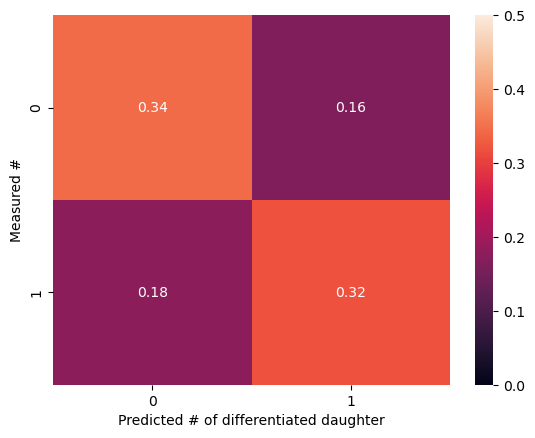

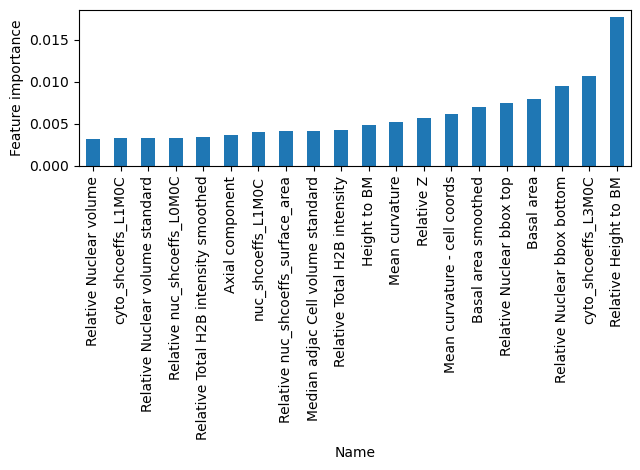

In [57]:
# Plot mother division model results
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.xlabel('Predicted # of differentiated daughter')
plt.ylabel('Measured #')
print(importances.mean().sort_values().tail(20))

plt.figure()
importances.mean().sort_values().tail(20).plot.bar(); plt.tight_layout();
plt.ylabel('Feature importance')


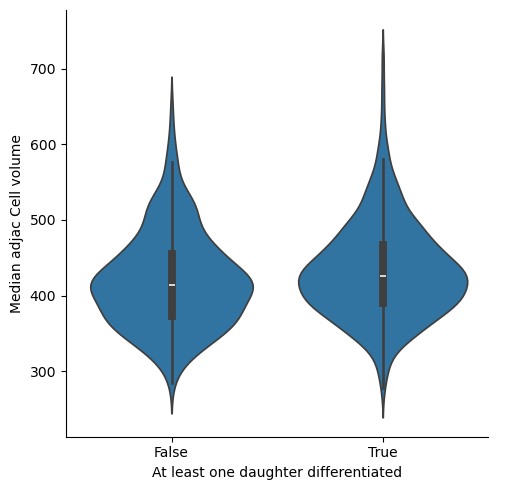

In [58]:
sb.catplot(df.droplevel(axis=1,level=1),x=feature2predict,y='Median adjac Cell volume',kind='violin')

## 4. 12h prior to mother division frame
- NB: Not enough cells

In [37]:
# Grab frame prior to mother division -- takes a while
from measurements import get_prev_or_next_frame

BALANCE = True
Niter = 100

df = all_df[all_df['Fate known','Meta']]
df = df[ df['Cell type','Meta'] == 'Basal']

divisions = df[df[('Divide next frame','Meta')]]
divisions = divisions[~divisions['Border','Meta'].astype(bool)]
divisions = divisions.reset_index()

prev_div_frame = [get_prev_or_next_frame(all_df,f,direction='prev') for _,f in tqdm(divisions.iterrows())]
prev_div_frame = pd.concat(prev_div_frame,axis=1).T
prev_div_frame = df[df[('Divide next frame','Meta')]]
prev_div_frame = prev_div_frame[~prev_div_frame['Border','Meta'].astype(bool)]
prev_div_frame = prev_div_frame.reset_index().set_index('TrackID')


668it [00:00, 1043.36it/s]


In [49]:
feature2predict = 'At least one daughter differentiated'
# feature2predict = 'Both daughters differentiated'
# feature2predict = 'Num daughter differentiated'

# Drop unneeded features
features2drop = [f for f in prev_div_frame.columns.get_level_values(0) if 'Time' in f]
features2drop += [f for f in prev_div_frame.columns.get_level_values(0) if 'Age' in f]
features2drop = [(f,'Measurement') for f in features2drop]
features2drop = features2drop + [('Keep until first differentiation','Meta')]
# divisions = prev_div_frame.drop(columns=features2drop).dropna(subset=[(feature2predict,'Meta')])

# Run model
feature_names = prev_div_frame.xs('Measurement',axis=1,level=1).columns
importances = []
avg_confusion = np.zeros((Niter,2,2))

for i in tqdm(range(Niter)):
    
    if BALANCE:
        df_ = get_balanced_df_by_category(prev_div_frame, prev_div_frame[(feature2predict,'Meta')].values).dropna(axis=1)
    else:
        df_ = prev_div_frame

    _tmp = df_.xs('Measurement',level=1,axis=1).copy()
    _tmp[feature2predict] = df_[(feature2predict,'Meta')].copy()
    
    y = _tmp[feature2predict].values.astype(bool)
    X = preprocessing.scale(_tmp.drop(columns=feature2predict))
    
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.1)
    
    forest = ensemble.RandomForestClassifier().fit(X_train,y_train)
    
    y_pred = forest.predict(X_test)
    avg_confusion[i,...] = metrics.confusion_matrix(y_test,y_pred)/len(y_test)
    
    importances.append(forest.feature_importances_)

importances = pd.DataFrame(importances,columns=_tmp.columns.drop('At least one daughter differentiated'))


100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  6.21it/s]


Name
Relative cyto_shcoeffs_L3M1C          0.003566
cyto_shcoeffs_L3M1S                   0.003570
nuc_shcoeffs_L3M2S                    0.003677
Relative Nuclear volume               0.003693
Relative nuc_shcoeffs_L0M0C           0.003759
Mean adjac Cell volume standard       0.003979
Relative Nuclear volume standard      0.004024
cyto_shcoeffs_L1M0C                   0.004054
Relative nuc_shcoeffs_surface_area    0.004188
Axial component                       0.004342
nuc_shcoeffs_L1M0C                    0.004690
Relative Total H2B intensity          0.005140
Median adjac Cell volume standard     0.005425
Mean curvature                        0.006261
Height to BM                          0.006490
Mean curvature - cell coords          0.007855
Relative Nuclear bbox top             0.009696
cyto_shcoeffs_L3M0C                   0.010651
Relative Nuclear bbox bottom          0.011958
Relative Height to BM                 0.018914
dtype: float64


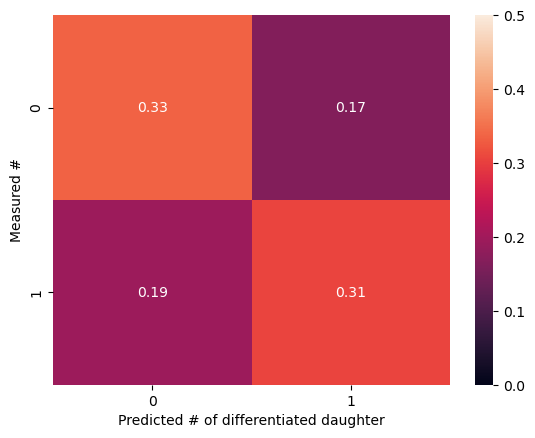

In [50]:
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.xlabel('Predicted # of differentiated daughter')
plt.ylabel('Measured #')
print(importances.mean().sort_values().tail(20))

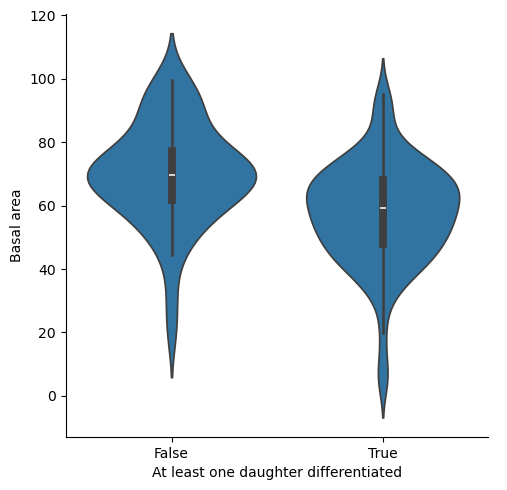

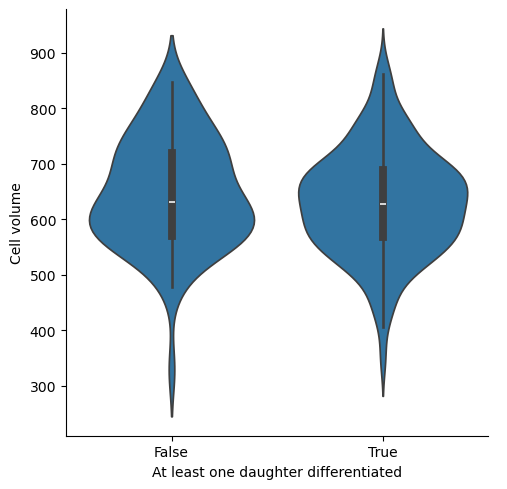

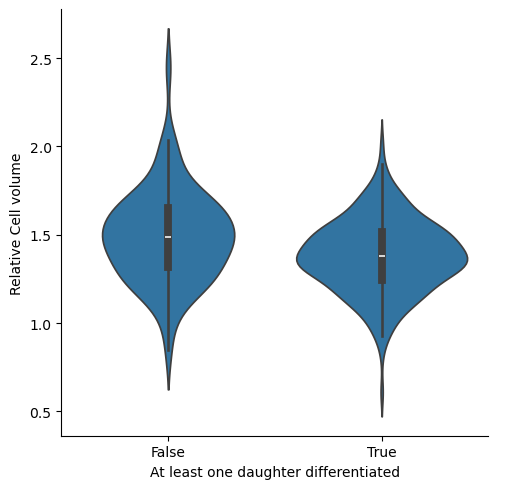

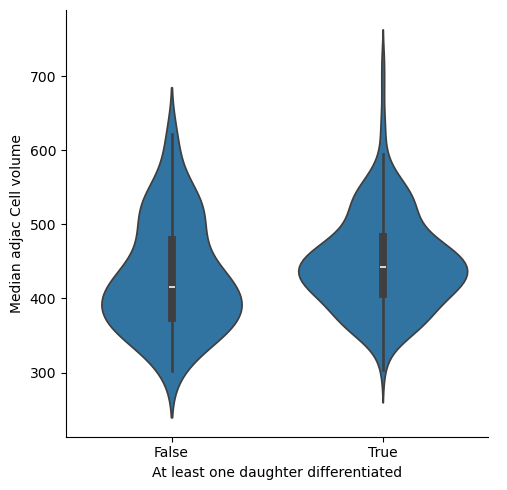

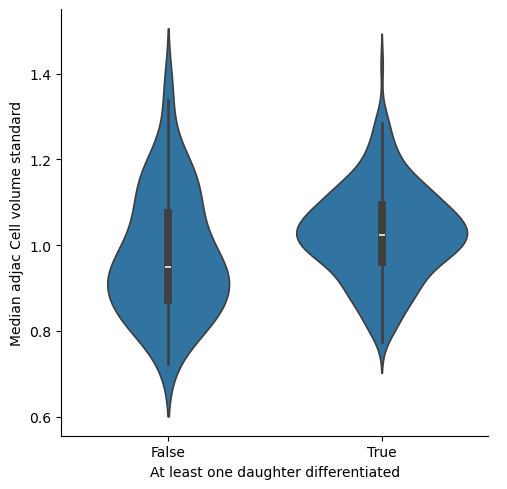

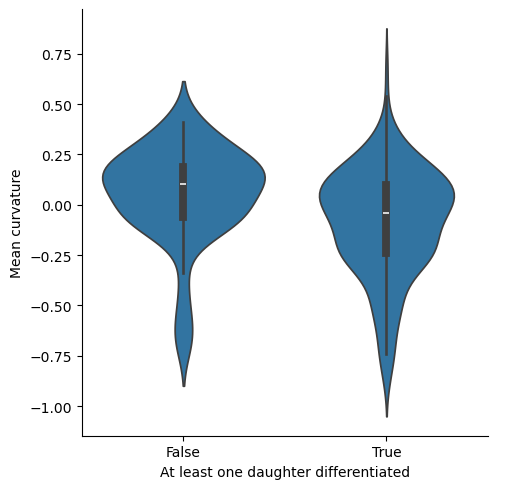

In [59]:

# Visualize features

sb.catplot(prev_div_frame.droplevel(level=1,axis=1),x=feature2predict,y='Basal area',kind='violin')
sb.catplot(prev_div_frame.droplevel(level=1,axis=1),x=feature2predict,y='Cell volume',kind='violin')
sb.catplot(prev_div_frame.droplevel(level=1,axis=1),x=feature2predict,y='Relative Cell volume',kind='violin')
sb.catplot(prev_div_frame.droplevel(level=1,axis=1),x=feature2predict,y='Median adjac Cell volume',kind='violin')
sb.catplot(prev_div_frame.droplevel(level=1,axis=1),x=feature2predict,y='Median adjac Cell volume standard',kind='violin')
# sb.catplot(prev_div_frame.droplevel(level=1,axis=1),x=feature2predict,y='Collagen intensity',kind='violin')
sb.catplot(prev_div_frame.droplevel(level=1,axis=1),x=feature2predict,y='Mean curvature',kind='violin')

### MISC: visualizations

<Figure size 640x480 with 0 Axes>

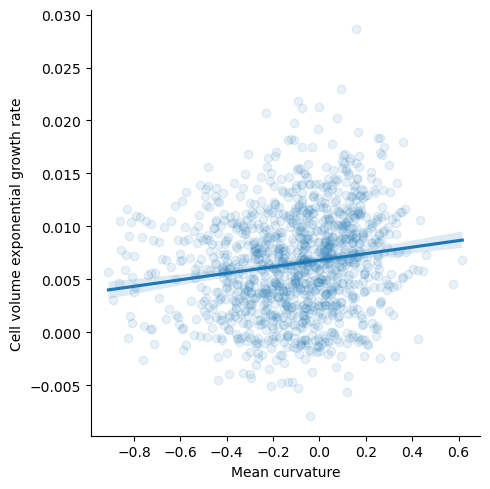

<Figure size 640x480 with 0 Axes>

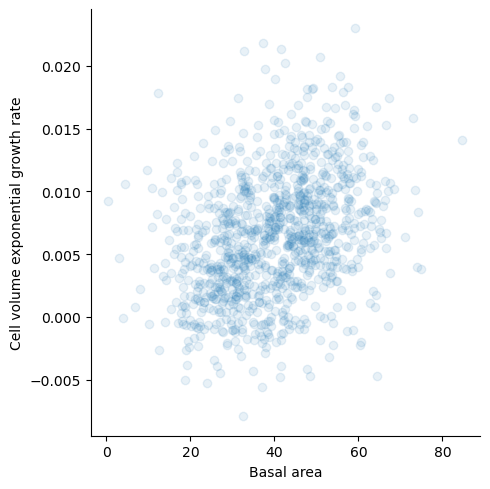

In [141]:
plt.figure()
x = 'Mean curvature'
y = 'Cell volume exponential growth rate'
sb.lmplot(all_df.droplevel(axis=1,level=1)[[x,y]].groupby('TrackID').mean(),x=x,y=y,
          scatter_kws={'alpha':0.1})

plt.figure()
x = 'Basal area'
y = 'Cell volume exponential growth rate'
sb.lmplot(all_df.droplevel(axis=1,level=1)[[x,y]].groupby('TrackID').mean(),x=x,y=y,
          scatter_kws={'alpha':0.1}, fit_reg=False)

In [231]:
all_df['Relative Nuclear volume']

Metadata      Measurement
Frame TrackID            
0     R1_1       1.168226
      R1_2       1.137992
      R1_5       1.115429
      R1_8       0.795531
      R1_11      0.824186
...                   ...
14    R2_1163         NaN
      R2_1173    0.897393
      R2_1175         NaN
      R2_1193         NaN
      R2_1198         NaN

[15087 rows x 1 columns]

Frame  TrackID
0      R1_1       1.168226
       R1_2       1.137992
       R1_5       1.115429
       R1_8       0.795531
       R1_11      0.824186
                    ...   
14     R2_1163         NaN
       R2_1173    0.897393
       R2_1175         NaN
       R2_1193         NaN
       R2_1198         NaN
Name: Relative Nuclear volume, Length: 15087, dtype: object

In [227]:
features2drop = [f for f in all_df.droplevel(axis=1,level=1).columns if 'smoothed' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'shcoeffs' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'prior' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'standard' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'BM' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'intensity' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'Time' in f]
A = all_df.droplevel(axis=1,level=1).drop(
    columns=['X','X-pixels','Y','Y-pixels','X-cyto','Y-cyto','Z','Z-cyto',
             'Daughter a','Daughter b','Mother','Sister']+features2drop).select_dtypes(numerics).corr(numeric_only=True)

B = A.abs().unstack().sort_values(ascending=False)

unique_pairs = []
# Iterate over the top pairs and add only unique pairs to the list
for pair in B.index:
    if pair[0] != pair[1] and (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)

# Create a dataframe with the top pairs and their correlation coefficients
corr_df = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr_coef'])
for i, pair in enumerate(unique_pairs):
    corr_df.loc[i] = [pair[0], pair[1], B.loc[pair[0], pair[1]]]

display(corr_df.dropna().head(50))


,feature_1,feature_2,corr_coef
0,Nuclear bbox bottom,Nuclear bbox top,0.979166
1,Nuclear volume exponential growth rate,Nuclear volume (filter_name) exponential growt...,0.919772
2,Cell volume exponential growth rate,Cell volume (filter_name) exponential growth rate,0.904737
3,Planar component 2,Planar component 1,0.823052
4,Axial component,Middle area,0.747579
5,Right,Left,0.747405
6,Mean curvature - cell coords,Nuclear bbox bottom,0.742856
7,Nuclear volume,Cell volume,0.731716
8,Nuclear bbox top,Mean curvature - cell coords,0.714124
9,Cell height,Planar component 1,0.693165


In [224]:
corr_df[(corr_df['feature_1'] == 'Mean curvature') | (corr_df['feature_2'] == 'Mean curvature')]


,feature_1,feature_2,corr_coef
27,Mean curvature,Nuclear bbox top,0.531308
32,Nuclear bbox bottom,Mean curvature,0.516032
39,Mean curvature,Mean curvature - cell coords,0.454429
54,Cell height,Mean curvature,0.360395
56,Mean curvature,Basal area,0.359866
81,Age,Mean curvature,0.280994
84,Left,Mean curvature,0.278783
87,Mean curvature,Nuclear volume,0.267515
100,Mean curvature,Planar component 1,0.238681
105,Planar component 2,Mean curvature,0.225305
